## Paper replication test
This notebook attemps to replicate the method from 2016:
Surangsrirat, Decho, et al. "Support vector machine classification of Parkinson's disease and essential tremor subjects based on temporal fluctuation." 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC). IEEE, 2016.

We use the features proposed in the paper, and a classificator coming from this paper.
We use the pre-processing pipeline establised previsouly, which corresponds to our EMG data.

In [1]:
# requirements
import os
import sys
sys.path.insert(0,'..') # to add parent directory
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from utils.data_loader import PatientsRawData
from utils.preprocessing import preprocess_signal
from utils.augment_data import get_augmentation_indexes, augment_data
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score


### load data

In [2]:
data = PatientsRawData('../../data/Исходные файлы/')
data.load_data()
print(f' Data labels: {data.Y} for the total of {len(data.X)} data samples coming from patients: {data.patient}')
print('Explore a random data sample: ')
N = random.randint(0,len(data.X))
data.X[N].head()
data.get_emg_data()

 Data labels: ['Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right'] for the total of 41 data samples coming from patients: ['аста0101.txt', 'дюки0102.txt', 'керш0103.txt', 'лега0104.txt', 'сидо0105.txt', 'фрол0106.txt', 'хвал0107.txt', 'черк0108.txt', 'даке0101.txt', 'ершо0102.txt', 'кудр0103.txt', 'купр0104.txt', 'куту0105.txt', 'лити0106.txt', 'луче0107.txt', 'макс0108.txt', 'миро0109.txt', 'молю01010.txt', 'муха01011.txt', 'соко01012.txt', 'тихо01013.txt', 'ерми0101.txt', 'кова0102.txt', 'колг0103.txt', 'медв0104.txt', 'наза0105.txt', 'погр0106.txt', 'савв0107.txt', 'сави0108.txt', 'шелу0109.txt', 'бело0101.txt', 'гава0102.txt', 'голу0103.txt', 'грек0104.txt', 'губа0105.txt', 'павл0106.txt', 'пана0107.tx

### pre-process  data

In [3]:
# convert data to numpy
min_sequence = 10000000000
try:
    data.convert_to_numpy()
except:
    print('already converted, skipping!')
#preprocess all the data
for i in range(len(data.X)):
    one_patient_emg = data.X[i]
    for j, emg_channel in enumerate(one_patient_emg):
        if len(emg_channel)<min_sequence:
            min_sequence = len(emg_channel) 
        processed_signal =  preprocess_signal(emg_channel,  SamplingRate=500,  LF=60, HF=240, frequences_to_filter = [50, 100, 150, 200 ], order_butter=4, save_plot=False) 
        data.X[i][j]=processed_signal # save to the previous unprocessed signal
    print(f'Pre-processed patient {i}') 
for i in range(len(data.X)):
    data.X[i]=data.X[i][:,:min_sequence] # save to the previous unprocessed signal

SHAPE (67545,)
SHAPE (67545,)
SHAPE (67545,)
SHAPE (67545,)
Pre-processed patient 0
SHAPE (68835,)
SHAPE (68835,)
SHAPE (68835,)
SHAPE (68835,)
Pre-processed patient 1
SHAPE (69645,)
SHAPE (69645,)
SHAPE (69645,)
SHAPE (69645,)
Pre-processed patient 2
SHAPE (66195,)
SHAPE (66195,)
SHAPE (66195,)
SHAPE (66195,)
Pre-processed patient 3
SHAPE (68325,)
SHAPE (68325,)
SHAPE (68325,)
SHAPE (68325,)
Pre-processed patient 4
SHAPE (66255,)
SHAPE (66255,)
SHAPE (66255,)
SHAPE (66255,)
Pre-processed patient 5
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
Pre-processed patient 6
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
SHAPE (68265,)
Pre-processed patient 7
SHAPE (68565,)
SHAPE (68565,)
SHAPE (68565,)
SHAPE (68565,)
Pre-processed patient 8
SHAPE (68445,)
SHAPE (68445,)
SHAPE (68445,)
SHAPE (68445,)
Pre-processed patient 9
SHAPE (65490,)
SHAPE (65490,)
SHAPE (65490,)
SHAPE (65490,)
Pre-processed patient 10
SHAPE (69135,)
SHAPE (69135,)
SHAPE (69135,)
SHAPE (69135,)
Pre-processed p

### Select only hands from the data:
Since in the paper the EMG is taken from the hand, we will do the same here.
For Parkinson Left, the left hand is taken.
For Parkinson Right, the right hand is taken.
For ET the right hand is taken.

In [4]:
num_et = data.Y.count('ET')
num_pd = data.Y.count('Left') + data.Y.count('Right') 

In [5]:
parkinson_data = np.zeros((num_pd,min_sequence)) # PD
et_data = np.zeros((num_et, min_sequence)) # ET

In [6]:
n, m = 0, 0
for i in range(len(data.Y)):
    if data.Y[i]=='ET':
        et_data[n] = data.X[i][1,:]     
        n+=1
    elif data.Y[i]=='Left':
         parkinson_data[m] = data.X[i][0,:]   
         m +=1
    elif data.Y[i]=='Right':
        parkinson_data[m] = data.X[i][1,:]  
        m+=1        

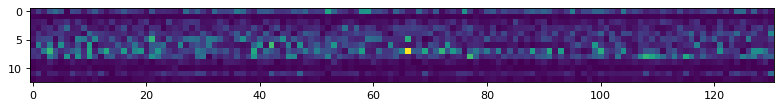

In [7]:
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(et_data[:,::500], interpolation='none')
plt.show()

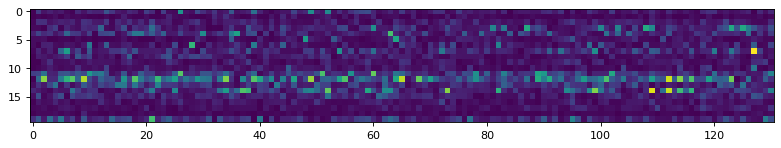

In [8]:
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(parkinson_data[:,::500], interpolation='none')
plt.show()

### Let's now transform the hand data into the 2D features used in the paper.
According to the publication, the features are calculated in  the following way.
Suppose s(n) is a sample of tremor time series, d1 and d2 are delay units
which d1 < d2. 
Let f(n) = (x(n), y(n)) be a two-dimensional signal representing a relation of tremor samples at different delay units d1 and d2 as:

f(n) = (x(n), y(n)) = ((s(n+ d1)-s(n)), (s(n+ d2)-s(n)))

Suppose, for example, time-delay units d1 and d2 are selected to 20 and 40 samples.

In [9]:
def calculate_2D(signal, d1=20, d2=40):
    signal2d = np.zeros((2, len(signal)-d2))
    for i in range(len(signal)-d2):
        signal2d[0,i] = signal[i+d1]-signal[i]
        signal2d[1,i]= signal[i+d2]-signal[i]
    return signal2d

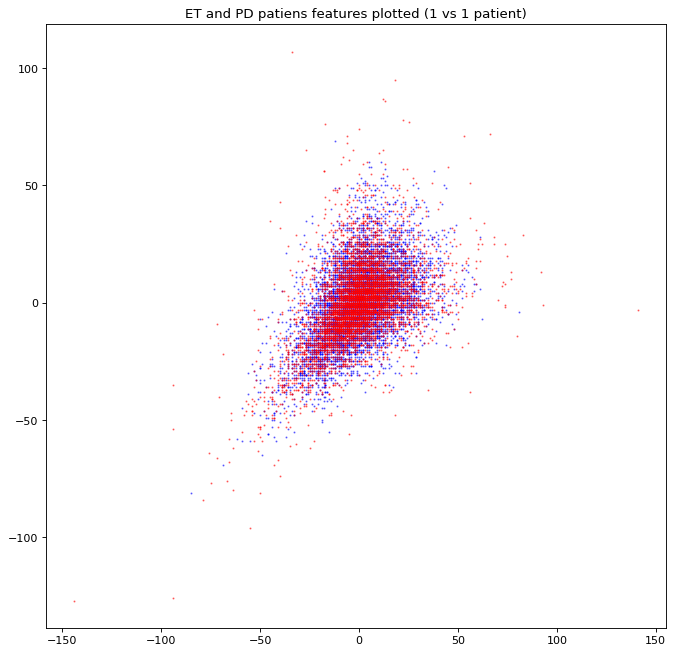

In [10]:
plt.figure(figsize=(10, 10), dpi=80)
transformed_et = calculate_2D(et_data[0])
transformed_pd=calculate_2D(parkinson_data[0])
plt.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.5, s=0.7)
plt.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.5, s=0.7)
# To show the plot
plt.title('ET and PD patiens features plotted (1 vs 1 patient)')
plt.show()

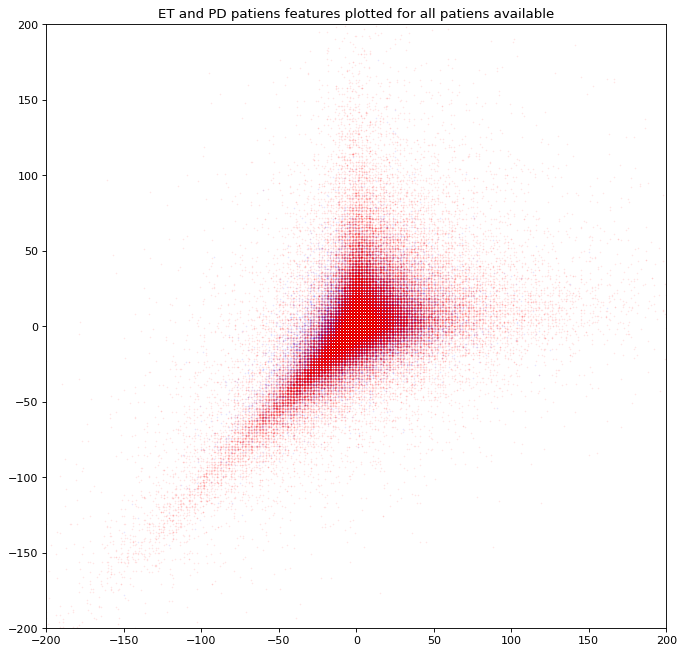

In [11]:
# let's try to get such features for all the data, and plot them side by side.
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i])
    plt.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j])
    plt.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
# To show the plot
plt.xlim([-200, 200])
plt.ylim([-200, 200])
# plt.yscale('log')
# plt.xscale('log')
plt.title('ET and PD patiens features plotted for all patiens available')
plt.show()

From the relation between two different unit-delay
versions of tremor signal, we simply draw a 95%
confidence ellipse for each task of individual PD and ET

In [47]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

-0.0017191097467382963 -0.0032233307751343056


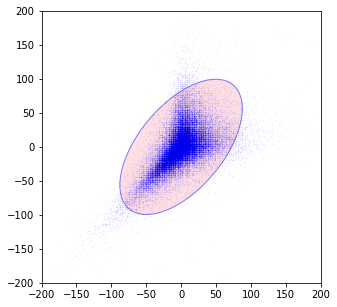

In [48]:
fig, ax_nstd = plt.subplots(figsize=(5, 5))
plt.scatter(transformed_pd[0], transformed_pd[1], c ="blue",alpha=0.2, s=0.01)
confidence_ellipse(transformed_pd[0], transformed_pd[1], ax_nstd, n_std=3,
                   label=r'$1\sigma$', edgecolor='blue',alpha=0.5, facecolor='pink',zorder=0)
plt.xlim([-200, 200])
plt.ylim([-200, 200])
plt.show()

Here is n example of the resulting data,  the confidence interval is equal to 95%.

In [53]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

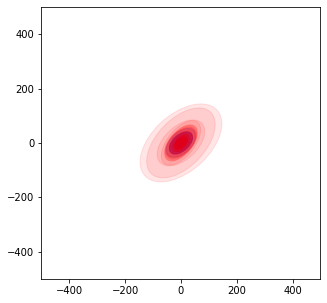

<Figure size 800x800 with 0 Axes>

In [92]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i])
    #ax.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_et[0], transformed_et[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='blue',alpha=0.2, facecolor='blue',zorder=0)
    ax.add_patch(el)

for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j])
#     ax.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_pd[0], transformed_pd[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='red',alpha=0.1, facecolor='red',zorder=0)
    ax.add_patch(el)

ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])

plt.show()